In [4]:
image_path = "./images/quan_nhau.jpg"

In [11]:
import textwrap
from IPython.display import Markdown


def to_markdown(text):
  text = text.replace('•', '  *')
  return Markdown(textwrap.indent(text, '> ', predicate=lambda _: True))

## 1. OCR

In [5]:
import easyocr

languages = ["en"]
GPU_READER = easyocr.Reader(languages, gpu=True)
results = GPU_READER.readtext(image_path)

boxes = [line[0] for line in results]
texts = [line[1] for line in results]
scores = [line[2] for line in results]

## 2. Captioning

In [6]:
import torch
from transformers import pipeline

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

captioning_pipe = pipeline("image-to-text", 
                           model="Salesforce/blip-image-captioning-base",
                           max_new_tokens = 512,
                           device = device)

In [8]:
from PIL import Image
img = Image.open(image_path).convert("RGB")

description = captioning_pipe(img)

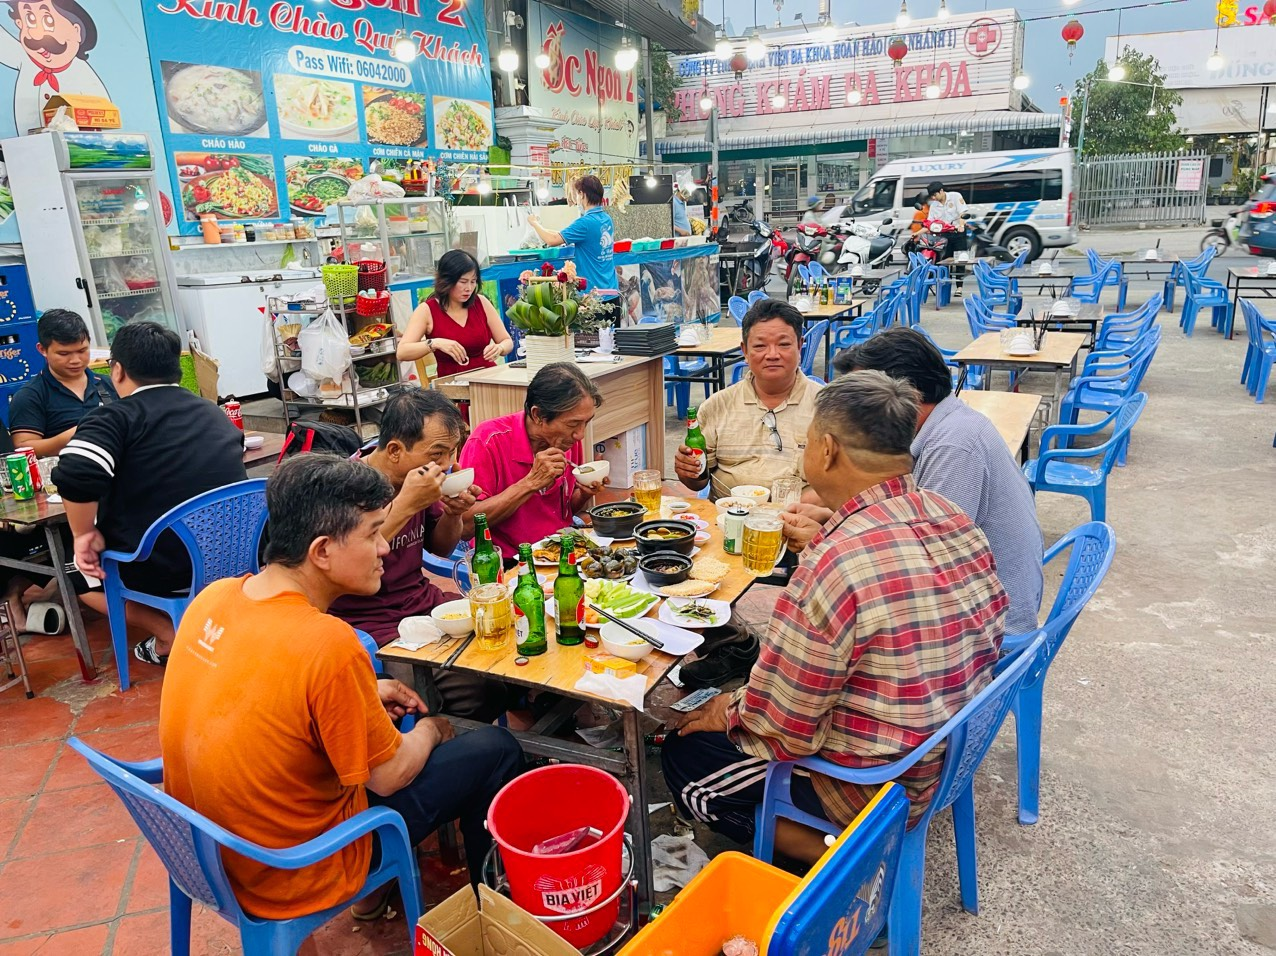

In [14]:
img

## 3. Analysis with LLM

In [9]:
import os
from groq import Groq

def analyze_image_information(image_description, ocr_results):
    prompt = f"""
    Analyze the following image information and provide insights based on the criteria given below:

    Image Description:
    {image_description}

    OCR Results:
    {ocr_results}

    Criteria:
    1. Brand Logos: Identify any brand logos mentioned in the description or OCR results.
    2. Products: Mention any products such as beer kegs and bottles.
    3. Customers: Describe the number of customers, their activities, and emotions.
    4. Promotional Materials: Identify any posters, banners, and billboards.
    5. Setup Context: Determine the scene context (e.g., bar, restaurant, grocery store, or supermarket).

    Insights:
    """


    client = Groq(
        api_key=os.getenv("GROQ_API_KEY"),
    )


    data = {
        "model": "llama3-8b-8192",
        "messages": [{"role": "user", "content": prompt}]
    }

    chat_completion = client.chat.completions.create(**data)
    return chat_completion.choices[0].message.content

In [12]:
image_description = description[0]['generated_text']
ocr_results = ' '.join(texts)

analysis = analyze_image_information(image_description, ocr_results)

In [13]:
to_markdown(analysis)

> Based on the image description and OCR results, here are the insights:
> 
> **Brand Logos:** None mentioned in the description or OCR results.
> 
> **Products:** None mentioned in the description or OCR results. However, the image description mentions "eating", which could imply that food and drinks are being consumed, but no specific products are mentioned.
> 
> **Customers:** The image description mentions a "group of people" sitting at a table, implying that there are multiple customers. Their activities appear to be eating and socializing, with no indication of emotions mentioned.
> 
> **Promotional Materials:** None mentioned in the description or OCR results.
> 
> **Setup Context:** The scene context appears to be a social gathering or a meal at a table, possibly in a private residence or a casual dining setting. It is not clear if this is a formal restaurant, bar, or grocery store/supermarket.
> 
> In summary, the image appears to capture a social gathering or meal at a table, involving multiple people eating and socializing, with no specific brand logos, products, or promotional materials mentioned. The scene context is not clearly identifiable as a specific type of establishment.